In [1]:
import json
from datetime import datetime
import warnings
from copy import deepcopy

import pandas as pd
import numpy as np
import SparseSC
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE

from synth_trainers import calculate_synths, calculate_synths_for_placebo
from vizualization_utils import vizualize_synth, vizualize_post_pre
from calc_utils import calculate_post_pre_mae_relations, try_calculate_p_values, NumpyEncoder

%matplotlib inline
pd.set_option("display.max_columns", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

In [2]:
df_grp = pd.read_csv('./datasets/in_grp_current.csv')
df_industry = pd.read_csv('./datasets/in_industry_production.csv')
df_investments = pd.read_csv('./datasets/in_investments.csv')
df_fixed_assets = pd.read_csv('./datasets/in_fixed_assets.csv')

In [3]:
def prepare_df(df):
    df.index = df['region'].str.rstrip().str.lower()
    df.drop(columns='region', inplace=True)
    df.columns = df.columns.str.slice(stop=4).astype(int)    
    for colname in df.columns:
        df[colname] = pd.to_numeric(df[colname], errors='coerce')
        df[colname] = df[colname].fillna(df[colname].dropna().mean())
    return df

In [4]:
df_grp = prepare_df(df_grp)
df_industry = prepare_df(df_industry)
df_investments = prepare_df(df_investments)
df_fixed_assets = prepare_df(df_fixed_assets)

In [5]:
wiki_url = 'https://en.wikipedia.org/wiki/List_of_special_economic_zones_in_India'
zones_df = pd.read_html(wiki_url)[2]
zones_df['Notification Date'] = pd.to_datetime(zones_df['Notification Date'])
zones_df.groupby(by='DC Name')['Notification Date'].min()

DC Name
Andhra Pradesh Special Economic Zone   2007-12-04
Cochin Special Economic Zone           2000-01-11
DC SEEPZ SEZ Mumbai                    2000-11-01
Falta Special Economic Zone            2003-01-01
Indore Special Economic Zone           2003-01-08
Kandla Special Economic Zone           2000-01-11
MEPZ Special Economic Zone             2003-01-01
Mangalore Special Economic Zone        2007-06-11
Noida Special Economic Zone            2003-01-01
Salem Special Economic Zone            2007-11-04
Vishakhapatnam Special Economic Zone   1989-03-15
Name: Notification Date, dtype: datetime64[ns]

In [6]:
sezs_region_and_year = [
    ('andhra pradesh', 2007),   # Andhra Pradesh Special Economic Zone
    ('karnataka', 2007),        # Mangalore Special Economic Zone
    ('tamil nadu', 2003),       # Salem Special Economic Zone & MEPZ Special Economic Zone 
    ('madhya pradesh', 2003),   # Indore Special Economic Zone
    ('west bengal', 2003),      # Falta Special Economic Zone
    ('uttar pradesh', 2003)     # Noida Special Economic Zone
]
LIST_OF_REGIONS_WITH_SEZS = [x for x, y in sezs_region_and_year]

In [7]:
for rname in LIST_OF_REGIONS_WITH_SEZS:
    for df in [df_grp, df_industry, df_investments, df_fixed_assets]:
        if rname not in df.index.tolist():
            print(f'{rname} is not present')
print('finished, all names are present')

finished, all names are present


In [8]:
df_grp.head(3)

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a & n islands,19027.000,21277.000,23558.000,50869.000,61282.000,67497.000,78683.000,89689.000,84934.000,93857.000,98875.000,108169.000,122774.000,139237.000,181264,204420,253839,298977,347985,411965,434314,397843,442118,502263,547722,603173,683587,789041,900318,976500.000,66345843.839,81326708.350
andhra pradesh,3462195.000,4175082.000,4418353.000,5786664.000,6892337.000,7985358.000,9014743.000,9578227.000,11493710.000,12879712.000,14472302.000,15671069.000,16709609.000,19001651.000,13476688,14760642,17406428,21236071,23738349,27332661,31986394,37940203,41140371,46427201,52497564,60422862,68441587,78613542,87372111,96609905.000,101437379.000,120173552.000
arunachal pradesh,50769.000,62906.000,74074.000,89311.000,96965.000,118440.000,121229.000,133652.000,151516.000,161177.000,178747.000,210412.000,207120.000,236772.000,348751,375515,410799,481000,568732,747445,902144,1106269,1254662,1458107,1795941,1850916,1990212,2247478,2533487,3003397.000,3127309.000,81326708.350


In [9]:
df_industry.head(3)

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
andaman & nicobar islands,537.400,646.700,610.000,763.000,966.300,1679.700,1172.700,1588.300,867.400,660.200,357.200,224.600,118.800,800.500,6638.000,9400.000,10391.000,11886.000,15254.000,22669.000,16327.000,17966.000,16526,18397,18400,13822,13322,14328,4402,3871
andhra pradesh,166080.000,199363.500,251267.700,283754.500,376189.600,462791.100,444433.600,567523.000,491794.200,584939.800,613470.200,639195.200,822864.200,826083.700,10238450.000,11801646.000,15816396.000,18253326.000,21240271.000,23446174.000,34356018.000,39093376.000,20712819,26268382,25191880,23377645,26583434,31121259,37614334,40046283
assam,28869.000,33748.400,37352.500,36828.900,43158.500,56694.700,59435.600,75129.000,80784.900,77759.200,87414.400,80227.600,125060.900,163062.300,2205002.000,2560914.000,3047619.000,3104360.000,3676790.000,3667156.000,4236700.000,5292766.000,4985210,5761714,6176083,5978808,6293606,6732646,8100540,7748672


In [10]:
df_investments.head(3)

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
andaman & nicobar islands,438.600,462.600,847.400,1073.700,1851.600,1809.300,1695.800,2000.700,657.000,577.600,361.500,288.600,187.500,904.900,8082.000,7920.000,7442.000,6746.000,6623.000,8745.000,5010.000,4967.000,4375,4468,3751,3270,2666,3449,2414,2258
andhra pradesh,203616.100,221442.500,258689.100,287345.500,334892.000,343968.000,346261.500,424973.800,355816.900,386899.000,391211.000,424705.800,463708.600,482070.500,5200094.000,5985776.000,7546449.000,9583545.000,10960697.000,17414928.000,22614430.000,32594218.000,16687679,19463961,19590584,21368799,23844352,23994086,25433421,27357821
assam,15230.400,19465.400,23080.400,21844.900,27916.900,38054.900,31422.800,56353.700,32726.300,38550.400,73087.300,50432.500,79022.300,93207.900,1022608.000,1090976.000,1179526.000,1301965.000,1361928.000,1466773.000,1739924.000,2185871.000,1927084,2135656,2582876,3960000,3736145,3660320,3954367,4173065


In [11]:
df_fixed_assets.head(3)

,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
andaman & nicobar islands,236.100,222.400,503.200,579.500,318.100,994.300,1004.800,1291.100,225.900,217.000,197.800,202.900,107.800,864.900,7696.000,7304.000,6655.000,5870.000,5586.000,7780.000,3960.000,3906.000,3256,3185,2309,1904,1536,2142,1511,1378
andhra pradesh,157790.800,171354.000,199656.300,222443.300,249641.700,243653.600,250063.500,316836.000,258050.600,271203.700,263378.800,300724.800,320618.600,342160.900,3526698.000,3932393.000,5108918.000,6425102.000,7439952.000,13028052.000,16010879.000,25393903.000,13081848,14862643,14824439,16820478,18632079,18444500,18875049,20654656
assam,10320.900,13344.600,15994.500,15190.500,19368.700,27017.000,21059.800,42548.200,22671.900,24761.800,55499.800,36040.200,59641.200,66955.900,702998.000,752035.000,801962.000,891081.000,940427.000,980140.000,1074713.000,1515746.000,1310951,1444632,1616940,3204850,2802255,2733666,3063797,3185207


In [12]:
DATAFRAMES = {
    'grp': df_grp, 
    'industry': df_industry, 
    'investments': df_investments,
    'fixed_assets': df_fixed_assets
}

In [14]:
synths_for_each_region = {}
for current_region, current_year in sezs_region_and_year:
    print(f"Calculating for {current_region}")
    synths_for_each_region[current_region] = calculate_synths(current_region, current_year, LIST_OF_REGIONS_WITH_SEZS, DATAFRAMES)

Calculating for andhra pradesh
		 Calculating for grp
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>| 
		 Calculating for industry
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>| 
		 Calculating for investments
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>| 
		 Calculating for fixed_assets
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>| 
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>| 
Calculating for karnataka
		 Calculating for grp
Calculating maximum covariate penalty (i.e. the gradient at zero) |>>>>>>>>>>>>>>>>>| 
Calculating maximum cov

In [15]:
print(sezs_region_and_year)

[('andhra pradesh', 2007), ('karnataka', 2007), ('tamil nadu', 2003), ('madhya pradesh', 2003), ('west bengal', 2003), ('uttar pradesh', 2003)]


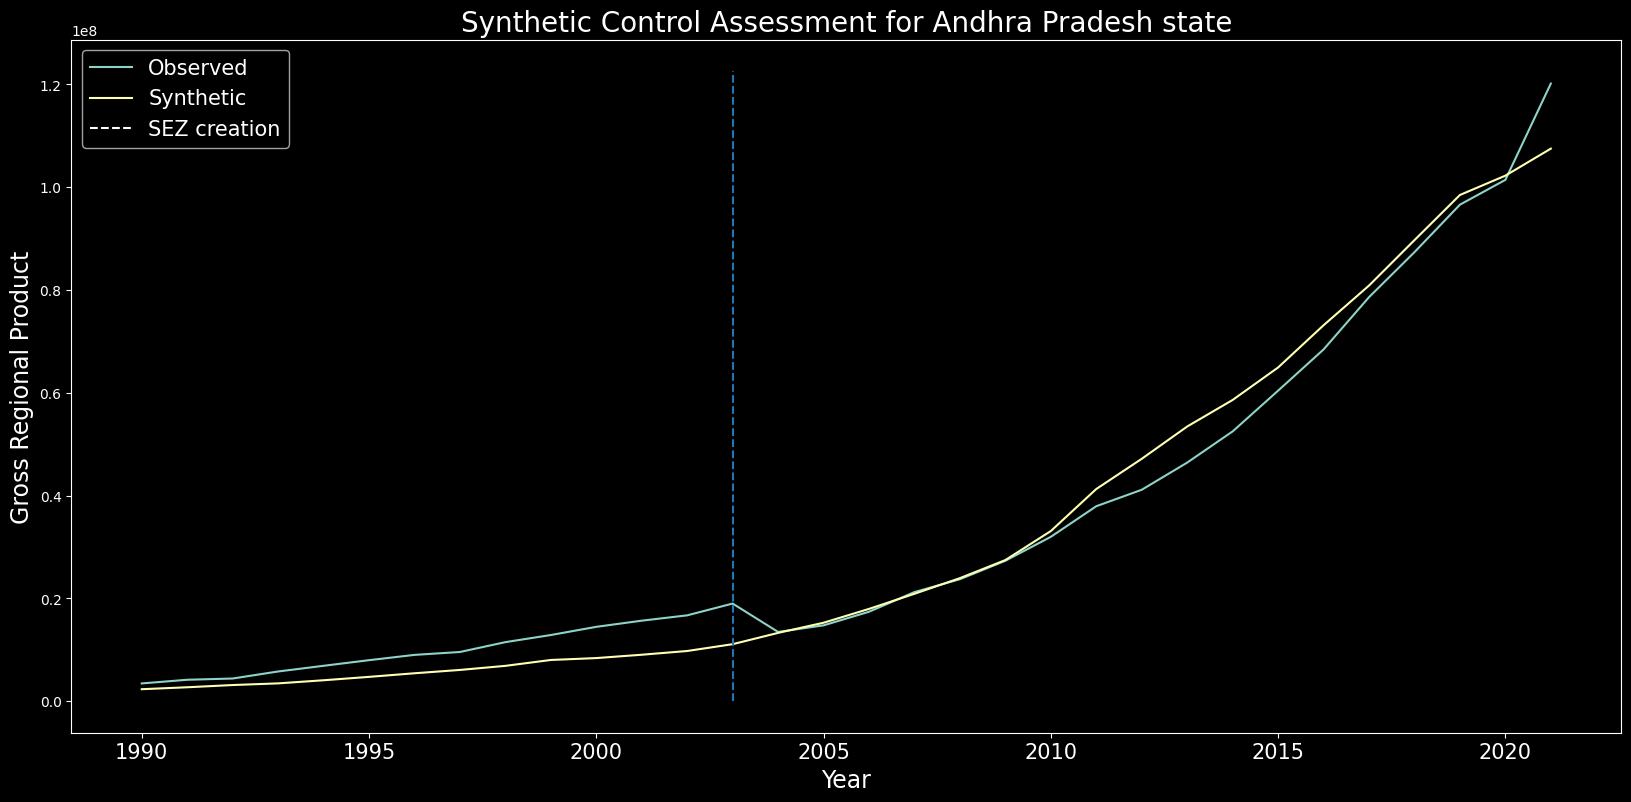

In [38]:
df = synths_for_each_region['andhra pradesh']['grp']['res_df']
region_annotation = 'Andhra Pradesh state'
variable_annotation = 'Gross Regional Product'
year = synths_for_each_region['uttar pradesh']['treatment_year']
vizualize_synth(df, region_annotation, variable_annotation, year)

In [17]:
print(sezs_region_and_year)

[('andhra pradesh', 2007), ('karnataka', 2007), ('tamil nadu', 2003), ('madhya pradesh', 2003), ('west bengal', 2003), ('uttar pradesh', 2003)]


In [39]:
df = synths_for_each_region['andhra pradesh']['grp']['res_df']
treatment_year = synths_for_each_region['andhra pradesh']['treatment_year']
mae_pre = MAE(df[df['year'] <= treatment_year]['Observed'].values, df[df['year'] <= treatment_year]['Synthetic'].values)
mae_post = MAE(df[df['year'] > treatment_year]['Observed'].values, df[df['year'] > treatment_year]['Synthetic'].values)
pd.DataFrame({
    'Pre': [mae_pre],
    'Post': [mae_post],
    'Post/Pre': [mae_post/mae_pre]
}, index=['MAE'])

,Pre,Post,Post/Pre
MAE,3216104.544,3797375.665,1.181


In [23]:
synths_for_placebo = {}
for i in range(4):
    current_region = df_grp.index.values[np.random.randint(0, len(df_grp))]
    current_year = 2011
    
    while current_region in LIST_OF_REGIONS_WITH_SEZS or current_region in list(synths_for_placebo.keys()):
        current_region = df_grp.index.values[np.random.randint(0, len(df_grp))]


    print(f"Calculating for {current_region}")
    synths_for_placebo[current_region] = calculate_synths_for_placebo(current_region, current_year, LIST_OF_REGIONS_WITH_SEZS, DATAFRAMES)

Calculating for kerala
Unique weights not possible.
Matrix is singular. occurred for industry
Calculating for delhi
Unique weights not possible.
Matrix is singular. occurred for industry
Calculating for puducherry
Unique weights not possible.
Matrix is singular. occurred for industry
Calculating for manipur
Unique weights not possible.
Matrix is singular. occurred for industry


In [24]:
post_pre_relations = calculate_post_pre_mae_relations(synths_for_placebo, synths_for_each_region, sezs_region_and_year)

In [25]:
colors = ['cyan' for _ in range(len(post_pre_relations['grp']['x']) - len(list(synths_for_placebo.keys())))]
colors.extend(['green'] * len(list(synths_for_placebo.keys())))

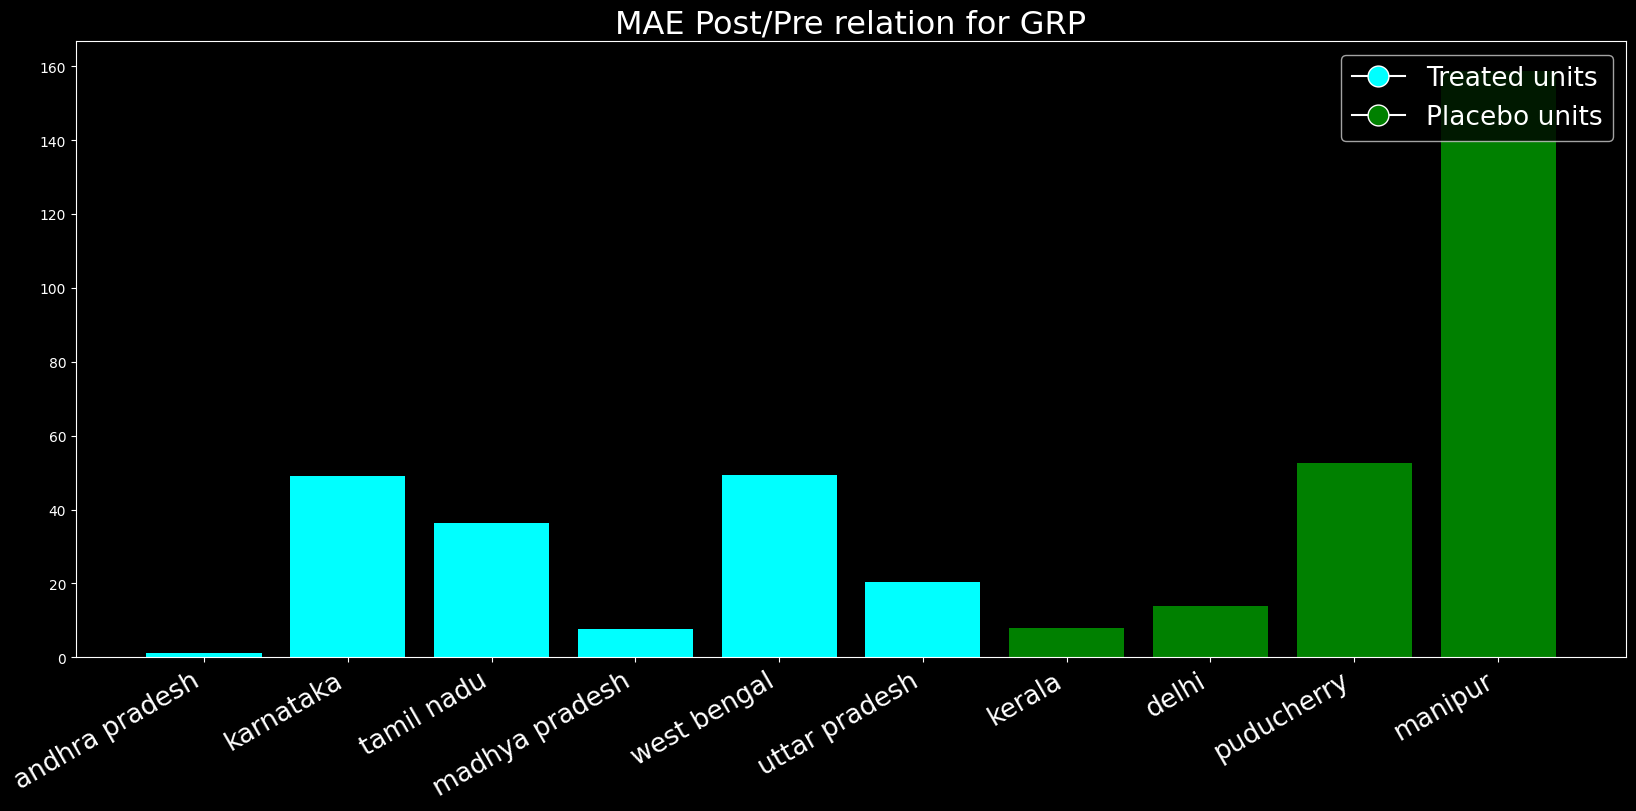

In [26]:
variable_dict = post_pre_relations['grp']
variable_name = 'GRP'
vizualize_post_pre(variable_dict, variable_name, colors)

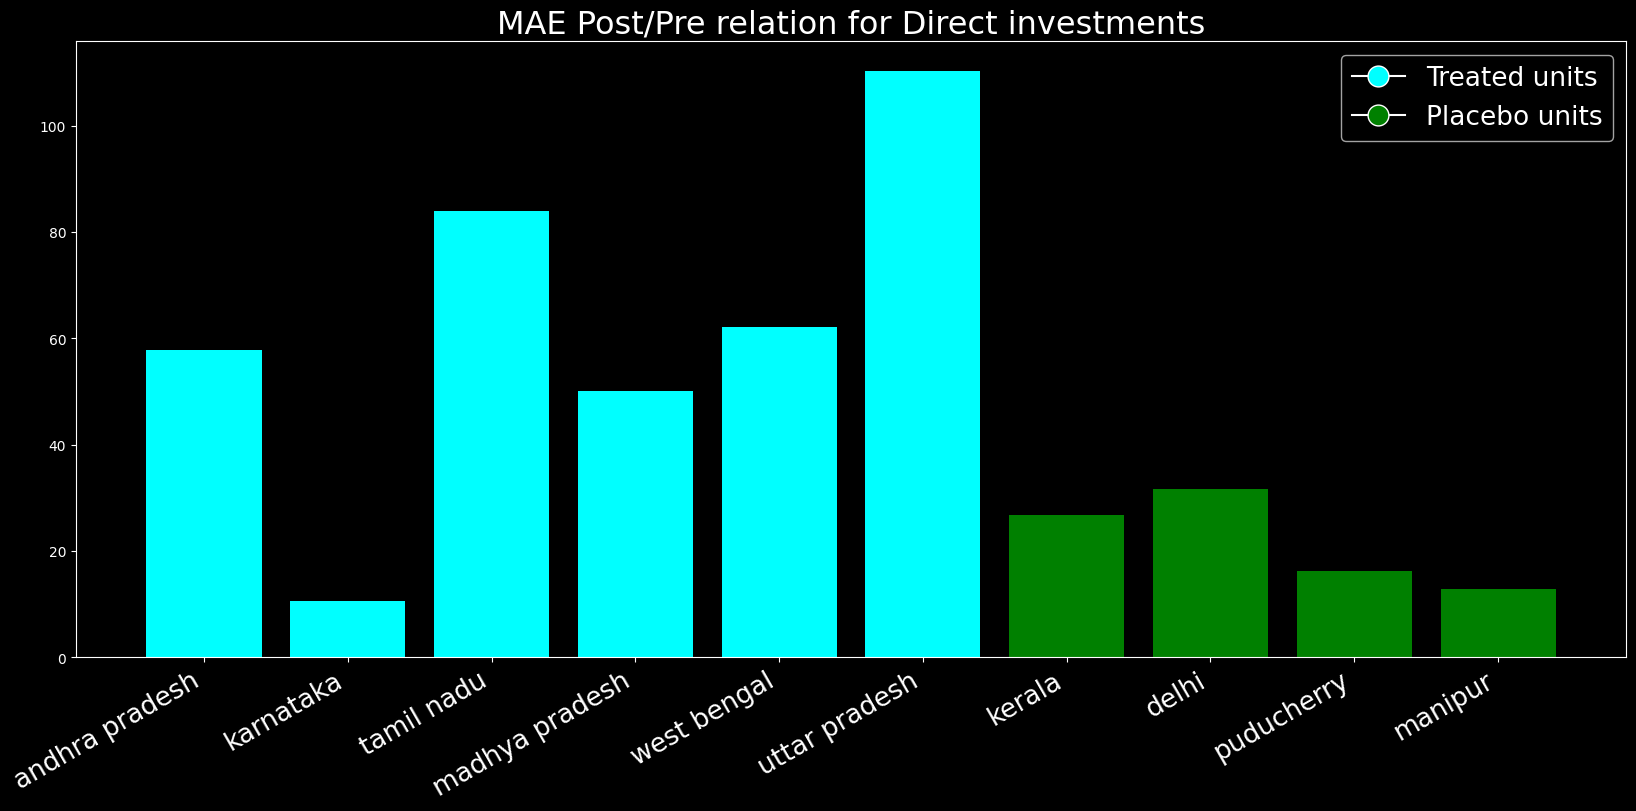

In [27]:
variable_dict = post_pre_relations['investments']
variable_name = 'Direct investments'
vizualize_post_pre(variable_dict, variable_name, colors)

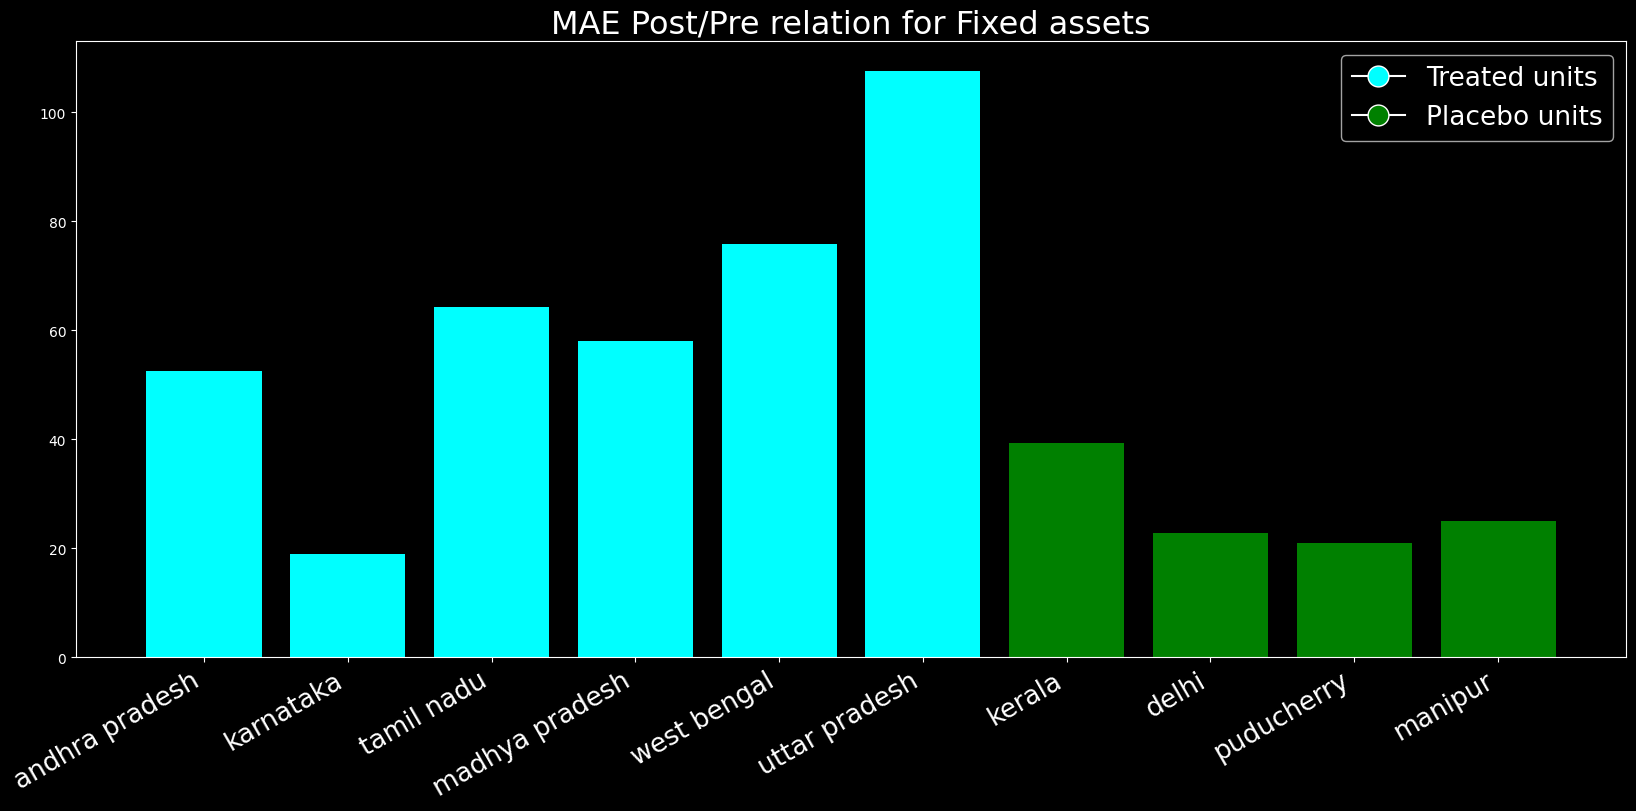

In [28]:
variable_dict = post_pre_relations['fixed_assets']
variable_name = 'Fixed assets'
vizualize_post_pre(variable_dict, variable_name, colors)

In [31]:
filename = 'p_for_india.txt'
try_calculate_p_values(filename, sezs_region_and_year, synths_for_each_region, DATAFRAMES)

Calculating for ('andhra pradesh', 2007)
Unique weights not possible.
Matrix is singular. occured for andhra pradesh, grp
Unique weights not possible.
Matrix is singular. occured for andhra pradesh, industry
Unique weights not possible.
Matrix is singular. occured for andhra pradesh, investments
Unique weights not possible.
Matrix is singular. occured for andhra pradesh, fixed_assets
Calculating for ('karnataka', 2007)
Unique weights not possible.
Matrix is singular. occured for karnataka, grp
Unique weights not possible.
Matrix is singular. occured for karnataka, industry
Unique weights not possible.
Matrix is singular. occured for karnataka, investments
Unique weights not possible.
Matrix is singular. occured for karnataka, fixed_assets
Calculating for ('tamil nadu', 2003)
Unique weights not possible.
Matrix is singular. occured for tamil nadu, industry
Unique weights not possible.
Matrix is singular. occured for tamil nadu, investments
Unique weights not possible.
Matrix is singular

In [34]:
result = {'treated': deepcopy(synths_for_each_region), 'placebo': deepcopy(synths_for_placebo)}

In [35]:
for synth_group in result.keys():
    for rname in result[synth_group].keys():
        for variable in result[synth_group][rname].keys():
            if variable != 'treatment_year':
                result[synth_group][rname][variable]['synth'] = {
                    'weights': result[synth_group][rname][variable]['synth'].get_weights(True),
                    'v_matrix': result[synth_group][rname][variable]['synth'].V,
                    'v_pen': result[synth_group][rname][variable]['synth'].fitted_v_pen,
                    'w_pen': result[synth_group][rname][variable]['synth'].fitted_w_pen
                }
                result[synth_group][rname][variable]['res_df'] = result[synth_group][rname][variable]['res_df'].to_dict()

In [36]:
with open("./results/result_india.json", "w") as outfile:
    json.dump(result, outfile, indent=4, cls=NumpyEncoder)